# Persiapan Library

In [1]:
import re
import string
import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
import pandas as pd
import nltk
import ast
import requests
import csv
from io import StringIO
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import pickle
from sklearn.utils import compute_class_weight
nltk.download('punkt_tab')  
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\alfth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alfth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Import Dataset

In [2]:
df = pd.read_csv('ulasan_aplikasi_gojek_100k.csv')
df

,Review,Rating
0,terlalu terlalu terlalu... apk yg tidak bisa d...,1
1,"Gak usah pasang tarif tarif hemat, soalnya par...",1
2,tinggal 2menit lg driver sampe di lokasi tiba-...,1
3,sebagai pengguna lama baru kali ini saya kecew...,1
4,susah untuk dpt driver walaupun di map ada ban...,1
...,...,...
130495,Cuman lupa email semua transaksi hafal akun ma...,1
130496,Untuk apk gojek tetap di pertahankan dalam pel...,5
130497,Dengan Go-Jek saya lebih terbantu kalau mau pe...,5
130498,Driverny pada blagu2.aplikasi on tapi gak mau ...,1


# Import Stopword ID tambahan

In [3]:
def getStopWordList(url):
    response = requests.get(url)
    response.raise_for_status()  
    content = response.text
    stopWords = content.splitlines()  # Split the content into lines to create the stopword list
    return stopWords

stopwords_tambahan = getStopWordList('https://raw.githubusercontent.com/yasirutomo/python-sentianalysis-id/master/data/feature_list/stopwordsID.txt')
stopwords_tambahan.pop(0)
stopwords_tambahan += ['gojek','driver','aplikasi','iya']

# Import Slangword ID tambahan

In [4]:


def getSlangWordList(url):
    response = requests.get(url)
    response.raise_for_status()  
    content = response.text
    data_dict = ast.literal_eval(content)
    return data_dict

slangwords = getSlangWordList('https://raw.githubusercontent.com/louisowen6/NLP_bahasa_resources/master/combined_slang_words.txt')
slangwords['gak'] = 'tidak'
slangwords['ga'] = 'tidak'
slangwords['bagu'] = 'bagus'
slangwords['gk'] ='tidak'
slangwords['udh'] = 'sudah'
slangwords['sdh'] = 'sudah'



# Assesing Dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130500 entries, 0 to 130499
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  130499 non-null  object
 1   Rating  130500 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ MB


In [6]:
df.shape

(130500, 2)

In [7]:
df.isnull().sum()

Review    1
Rating    0
dtype: int64

In [8]:
df.duplicated().sum()

643

In [9]:
df.groupby(by='Rating').count()

,Review
Rating,
1,54711
2,11633
3,11241
4,9183
5,43731


# Cleaning Dataset

In [10]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [11]:
print(df.isnull().sum())
print(df.duplicated().sum())

Review    0
Rating    0
dtype: int64
0


# Membuat Pipeline Processing

In [12]:
def processingText(text):
    # Cleaning Text
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text) 
    text = re.sub(r'RT[\s]', '', text) 
    text = re.sub(r"http\S+", '', text) 
    text = re.sub(r'[0-9]+', '', text) 
    text = re.sub(r'[^\w\s]', '', text) 

    text = text.replace('\n', ' ') 
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = text.strip(' ')

    # Casefolding Text
    text = text.lower()

    #menggabungkan kata nomina (nya)
    text = re.sub(r'\b(\w+)\s+nya\b', r'\1nya', text)
    # Tokenizing Text
    text_tokenize = word_tokenize(text)

    # slangword fixing and stopword removal
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(stopwords_tambahan)

    filtered = []
    for txt in text_tokenize:
        token_fixed = slangwords.get(txt, txt)
        if token_fixed not in listStopwords:
            filtered.append(token_fixed)

    return filtered



In [13]:
df_clean = df.copy()
df_clean['tokenizing_clean'] = df_clean['Review'].apply(processingText)
df_clean['final_text'] = df_clean['tokenizing_clean'].apply(lambda x: ' '.join(x))
df_clean.head()

,Review,Rating,tokenizing_clean,final_text
0,terlalu terlalu terlalu... apk yg tidak bisa d...,1,"[apk, percaya, kuota, cepat, habis, update, bu...",apk percaya kuota cepat habis update bug hp la...
1,"Gak usah pasang tarif tarif hemat, soalnya par...",1,"[pasang, tarif, tarif, hemat, drivernya, ambil...",pasang tarif tarif hemat drivernya ambil order...
2,tinggal 2menit lg driver sampe di lokasi tiba-...,1,"[tinggal, menit, lokasi, tibatiba, dibatalin, ...",tinggal menit lokasi tibatiba dibatalin otomat...
3,sebagai pengguna lama baru kali ini saya kecew...,1,"[pengguna, kali, kecewa, gocar, kadang, sesuai...",pengguna kali kecewa gocar kadang sesuai harap...
4,susah untuk dpt driver walaupun di map ada ban...,1,"[susah, map, jalan, sekalinya, hujan, harga, l...",susah map jalan sekalinya hujan harga langsung...


# Membuat kamus data positif dan negatif

In [14]:

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()
response = requests.get('https://raw.githubusercontent.com/fajri91/InSet/master/positive.tsv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    next(reader)  
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()
response = requests.get('https://raw.githubusercontent.com/fajri91/InSet/master/negative.tsv')
if response.status_code == 200:
    reader = csv.reader(StringIO(response.text), delimiter='\t')
    next(reader) 
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])
else:
    print("Failed to fetch negative lexicon data")

In [15]:
def sentiment_analysis_lexicon_indonesia(text):
    score = 0

    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
        elif word in lexicon_negative:
            score += lexicon_negative[word]

    polarity = ''
    if score > 1:
        polarity = 'positive'
    elif score < -1:
        polarity = 'negative'
    else :
        polarity = 'neutral'

    return score, polarity


def sentiment_analysis_based_on_rating(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 3 and rating >= 2:
        return 'neutral'
    else:
        return 'negative'

In [16]:
results = df_clean['tokenizing_clean'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
df_clean['polarity_score_lexicon'] = results[0]
df_clean['polarity_lexicon'] = results[1]
print(df_clean['polarity_lexicon'].value_counts())

polarity_lexicon
positive    83536
negative    25456
neutral     20864
Name: count, dtype: int64


In [17]:
df_clean['polarity_rating'] = df_clean['Rating'].apply(sentiment_analysis_based_on_rating)

print(df_clean['polarity_rating'].value_counts())

polarity_rating
negative    54671
positive    52312
neutral     22873
Name: count, dtype: int64


In [18]:
df_clean

,Review,Rating,tokenizing_clean,final_text,polarity_score_lexicon,polarity_lexicon,polarity_rating
0,terlalu terlalu terlalu... apk yg tidak bisa d...,1,"[apk, percaya, kuota, cepat, habis, update, bu...",apk percaya kuota cepat habis update bug hp la...,-6,negative,negative
1,"Gak usah pasang tarif tarif hemat, soalnya par...",1,"[pasang, tarif, tarif, hemat, drivernya, ambil...",pasang tarif tarif hemat drivernya ambil order...,25,positive,negative
2,tinggal 2menit lg driver sampe di lokasi tiba-...,1,"[tinggal, menit, lokasi, tibatiba, dibatalin, ...",tinggal menit lokasi tibatiba dibatalin otomat...,9,positive,negative
3,sebagai pengguna lama baru kali ini saya kecew...,1,"[pengguna, kali, kecewa, gocar, kadang, sesuai...",pengguna kali kecewa gocar kadang sesuai harap...,26,positive,negative
4,susah untuk dpt driver walaupun di map ada ban...,1,"[susah, map, jalan, sekalinya, hujan, harga, l...",susah map jalan sekalinya hujan harga langsung...,16,positive,negative
...,...,...,...,...,...,...,...
130495,Cuman lupa email semua transaksi hafal akun ma...,1,"[cuman, lupa, email, transaksi, hafal, akun, n...",cuman lupa email transaksi hafal akun nyangkut...,8,positive,negative
130496,Untuk apk gojek tetap di pertahankan dalam pel...,5,"[apk, pertahankan, pelayanan, goride, dsb, min...",apk pertahankan pelayanan goride dsb min terim...,9,positive,positive
130497,Dengan Go-Jek saya lebih terbantu kalau mau pe...,5,"[terbantu, pesan, makan, tinggal, mengunakan]",terbantu pesan makan tinggal mengunakan,4,positive,positive
130498,Driverny pada blagu2.aplikasi on tapi gak mau ...,1,"[driverny, blaguaplikasi, narikkan, dongo]",driverny blaguaplikasi narikkan dongo,0,neutral,negative


# Eksplorasi Label

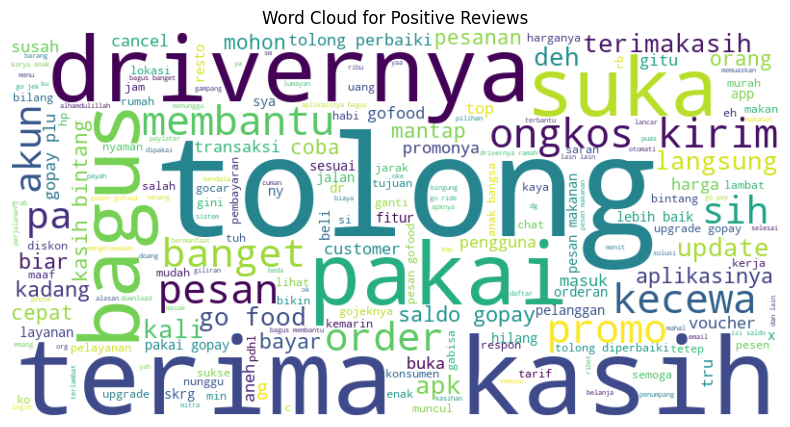

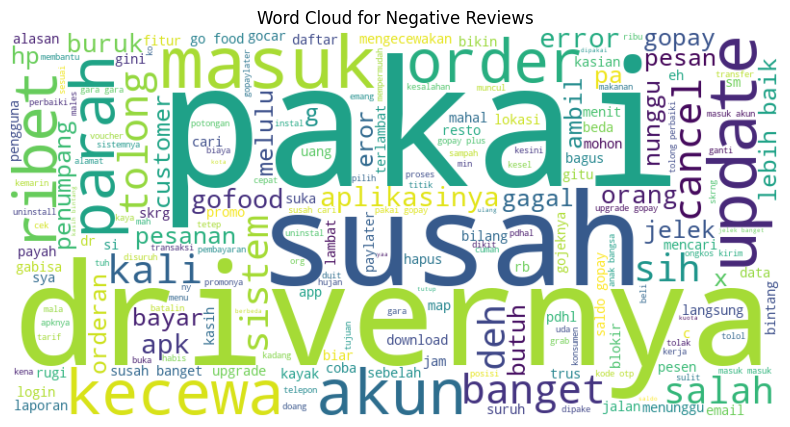

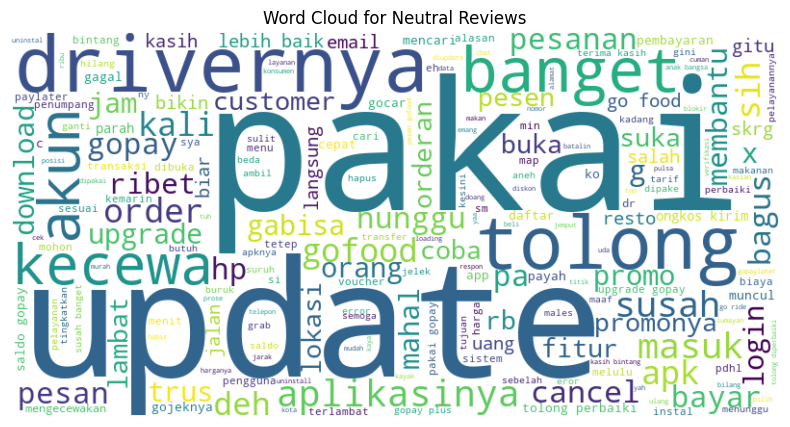

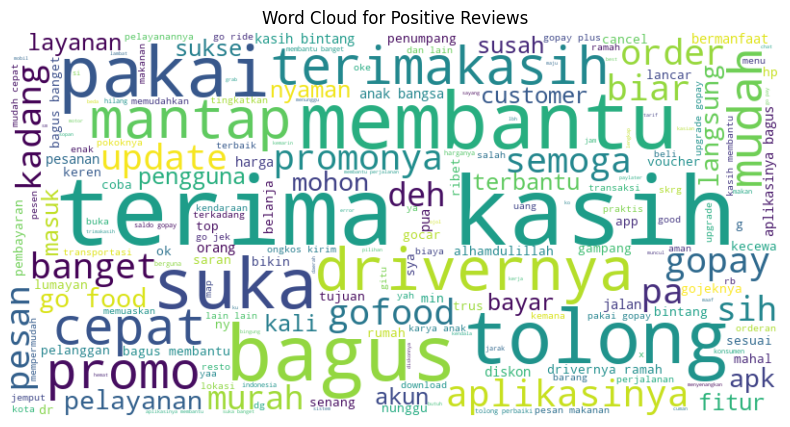

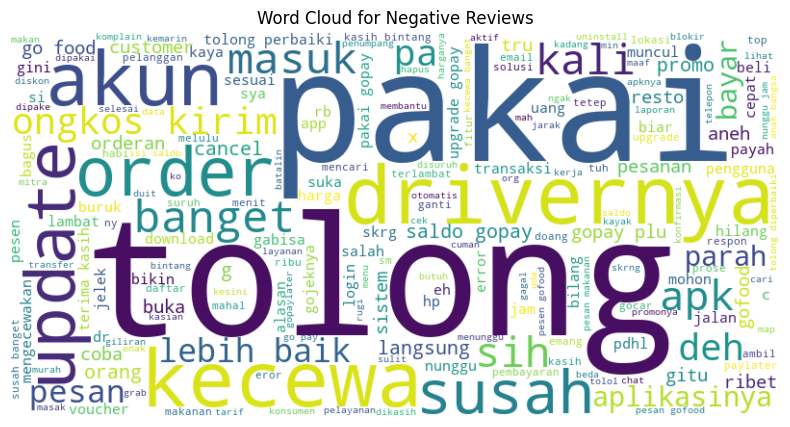

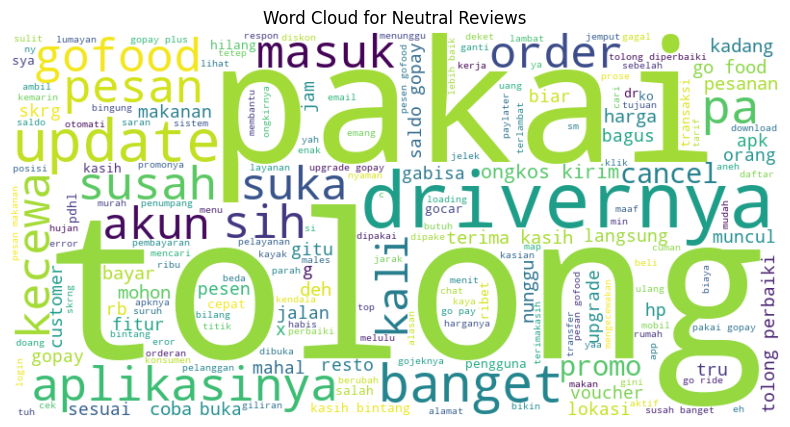

In [19]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt

labels = ['positive', 'negative', 'neutral']
for label in labels:
    text = ' '.join(df_clean[df_clean['polarity_lexicon'] == label]['final_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label.capitalize()} Reviews')
    plt.show()

labels = ['positive', 'negative', 'neutral']
for label in labels:
    text = ' '.join(df_clean[df_clean['polarity_rating'] == label]['final_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {label.capitalize()} Reviews')
    plt.show()

In [20]:
df_clean.head()

,Review,Rating,tokenizing_clean,final_text,polarity_score_lexicon,polarity_lexicon,polarity_rating
0,terlalu terlalu terlalu... apk yg tidak bisa d...,1,"[apk, percaya, kuota, cepat, habis, update, bu...",apk percaya kuota cepat habis update bug hp la...,-6,negative,negative
1,"Gak usah pasang tarif tarif hemat, soalnya par...",1,"[pasang, tarif, tarif, hemat, drivernya, ambil...",pasang tarif tarif hemat drivernya ambil order...,25,positive,negative
2,tinggal 2menit lg driver sampe di lokasi tiba-...,1,"[tinggal, menit, lokasi, tibatiba, dibatalin, ...",tinggal menit lokasi tibatiba dibatalin otomat...,9,positive,negative
3,sebagai pengguna lama baru kali ini saya kecew...,1,"[pengguna, kali, kecewa, gocar, kadang, sesuai...",pengguna kali kecewa gocar kadang sesuai harap...,26,positive,negative
4,susah untuk dpt driver walaupun di map ada ban...,1,"[susah, map, jalan, sekalinya, hujan, harga, l...",susah map jalan sekalinya hujan harga langsung...,16,positive,negative


#### Simpan dataset

In [21]:
df_clean.to_csv('ulasan_aplikasi_gojek_clean_100k.csv', index=False)

# Skema Pelatihan 1

#### LSTM dengan Tokenizer Tensorflow dan embedding pembagian data 80/20 dan labeling menggunakan lexicon

In [22]:
X = df_clean['final_text']
y = df_clean['polarity_lexicon']
encoder = LabelEncoder()
y = encoder.fit_transform(y)
print("Mapping label -> angka:", list(zip(encoder.classes_, range(len(encoder.classes_)))))

Mapping label -> angka: [('negative', 0), ('neutral', 1), ('positive', 2)]


In [23]:
max_words = 10000

In [24]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)



sample_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
sample_weights = dict(enumerate(sample_weights))

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=35,truncating='post', padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=35,truncating='post', padding='post')

In [25]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=100),
    Bidirectional(LSTM(128)),
    BatchNormalization(),                                     
    Dense(3, activation='softmax') 
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_pad, 
                    y_train, 
                    epochs=15, 
                    validation_data=(X_test_pad,y_test), 
                    callbacks=[early_stopping], 
                    class_weight=sample_weights,
                    batch_size=32)

Epoch 1/15
3247/3247 ━━━━━━━━━━━━━━━━━━━━ 132s 39ms/step - accuracy: 0.7464 - loss: 0.6356 - val_accuracy: 0.8907 - val_loss: 0.2592
Epoch 2/15
3247/3247 ━━━━━━━━━━━━━━━━━━━━ 127s 39ms/step - accuracy: 0.9064 - loss: 0.2720 - val_accuracy: 0.9267 - val_loss: 0.1976
Epoch 3/15
3247/3247 ━━━━━━━━━━━━━━━━━━━━ 147s 45ms/step - accuracy: 0.9424 - loss: 0.1750 - val_accuracy: 0.8996 - val_loss: 0.2843
Epoch 4/15
3247/3247 ━━━━━━━━━━━━━━━━━━━━ 135s 41ms/step - accuracy: 0.9596 - loss: 0.1240 - val_accuracy: 0.9240 - val_loss: 0.2308
Epoch 5/15
3247/3247 ━━━━━━━━━━━━━━━━━━━━ 133s 41ms/step - accuracy: 0.9707 - loss: 0.0927 - val_accuracy: 0.9322 - val_loss: 0.2338
Epoch 6/15
3247/3247 ━━━━━━━━━━━━━━━━━━━━ 141s 43ms/step - accuracy: 0.9785 - loss: 0.0678 - val_accuracy: 0.9292 - val_loss: 0.2501
Epoch 7/15
3247/3247 ━━━━━━━━━━━━━━━━━━━━ 145s 45ms/step - accuracy: 0.9822 - loss: 0.0573 - val_accuracy: 0.9392 - val_loss: 0.2414
Epoch 8/15
3247/3247 ━━━━━━━━━━━━━━━━━━━━ 139s 43ms/step - accuracy: 

In [26]:
y_test_pred = model.predict(X_test_pad)
y_test_pred = np.argmax(y_test_pred, axis=1)
y_train_pred = model.predict(X_train_pad)
y_train_pred = np.argmax(y_train_pred, axis=1)

812/812 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step
3247/3247 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step


In [27]:
print(f"Akurasi training: {accuracy_score(y_train,y_train_pred)}%")
print(f"Akurasi testing: {accuracy_score(y_test,y_test_pred)}%")

Akurasi training: 0.9906049054714874%
Akurasi testing: 0.9391652548898815%


#### Confussion Matrix

In [28]:
cm = confusion_matrix(y_test, y_test_pred)
cm

array([[ 4671,   401,    38],
       [  270,  3621,   267],
       [   35,   569, 16100]], dtype=int64)

#### Classification Report

In [29]:
print(classification_report(y_test, y_test_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

    negative       0.94      0.91      0.93      5110
     neutral       0.79      0.87      0.83      4158
    positive       0.98      0.96      0.97     16704

    accuracy                           0.94     25972
   macro avg       0.90      0.92      0.91     25972
weighted avg       0.94      0.94      0.94     25972



#### Simpan tokenizer dan model

In [30]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [31]:
model.save('bilstm_model.keras')

# Skema Pelatihan 2

###  Menggunakan Logistic Regression dengan ekstraksi Fitur TF-IDF, Komposisi data 70/30 dan label dari polarity lexicon

#### Persiapan dataset

In [32]:
X_logistic = df_clean['final_text']
y_logistic = df_clean['polarity_lexicon'].apply(lambda x : 0 if x =='negative' else (1 if x == 'neutral' else 2))

In [33]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_logistic, y_logistic, test_size=0.3, random_state=42, stratify=y_logistic
)

tfidf = TfidfVectorizer(
    max_features=10000,
    min_df=5,
    max_df=0.8,
    ngram_range=(1, 2)
)
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

In [34]:
model = LogisticRegression(max_iter=1000, solver='saga')
model.fit(X_train_tfidf,y_train)
y_pred_train = model.predict(X_train_tfidf)
print(f"Akurasi training Logistic Regression : {accuracy_score(y_train,y_pred_train)}")
y_pred_test = model.predict(X_test_tfidf)
print(f"akurasi testing Logistic Regression : {accuracy_score(y_test,y_pred_test)}")

Akurasi training Logistic Regression : 0.9130683505869152
akurasi testing Logistic Regression : 0.8746566727417409


In [35]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      7637
           1       0.75      0.47      0.57      6259
           2       0.91      0.98      0.94     25061

    accuracy                           0.87     38957
   macro avg       0.83      0.77      0.79     38957
weighted avg       0.87      0.87      0.86     38957



In [36]:
confusion_matrix(y_test, y_pred_test)

array([[ 6531,   709,   397],
       [ 1150,  2922,  2187],
       [  166,   274, 24621]], dtype=int64)

#### Simpan vectorizer dan Model

In [37]:
# Simpan vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [38]:
joblib.dump(model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

# Skema pelatihan 3 di notebook yang lain, dipisahkan dengan alasan efisiensi dan keterbacaan kode